In [1]:
!nvidia-smi

Tue Feb  1 14:49:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.86       Driver Version: 470.86       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
| 30%   28C    P8     4W / 350W |   5550MiB / 24259MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install ltp
!pip install -q -U watermark
!pip install -qq transformers
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

numpy       : 1.20.3
pandas      : 1.3.4
torch       : 1.10.0
transformers: 4.7.0



In [3]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import unicodedata
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import f1_score
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from collections import Counter
import ast
import random


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 10
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## New Section

In [4]:
# sns.countplot(df.label_norm)
# plt.xlabel('review score');

In [5]:
from transformers import BertTokenizer,BertModel
PRE_TRAINED_MODEL_NAME = "hfl/chinese-roberta-wwm-ext"
# PRE_TRAINED_MODEL_NAME = "hfl/chinese-roberta-wwm-ext-large"
# PRE_TRAINED_MODEL_NAME = "hfl/chinese-bert-wwm-ext"
# PRE_TRAINED_MODEL_NAME = "bert-base-uncased"
# PRE_TRAINED_MODEL_NAME = "ProsusAI/finbert"
# PRE_TRAINED_MODEL_NAME = "bert-base-chinese"

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,do_lower_case=True)
PRE_TRAINED_MODEL_NAME = '/home/bit/stock/model/pretrained-bert/ROBERT_4_model.bin'

## Map the position of LTP to Bert tokens

## Generating the masks of verb, A0, A1

In [6]:
df_train = pd.read_csv('../data/pre/train.csv',sep='\t')
df_val = pd.read_csv('../data/pre/val.csv',sep='\t')
df_test = pd.read_csv('../data/pre/test.csv',sep='\t')
df_ood = pd.read_csv('../data/pre/ood.csv',sep='\t')

df_train = df_train.drop(df_train.loc[df_train.verbA0A1.isna()].index)
df_test = df_test.drop(df_test.loc[df_test.verbA0A1.isna()].index)
df_val = df_val.drop(df_val.loc[df_val.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)

df_train = df_train.drop(df_train.loc[df_train.verbA0A1=='[]'].index)
df_test = df_test.drop(df_test.loc[df_test.verbA0A1=='[]'].index)
df_val = df_val.drop(df_val.loc[df_val.verbA0A1=='[]'].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)

def string_to_tuples_list(text):
  if text is np.nan or text =='[]':
    return []
  text = ''.join(text.split('], ['))
  tmp = eval(text.strip('[').strip(']'))
  if not isinstance(tmp[0],tuple):
    return [tmp]
  return list(tmp)





for col in ['verb','A0','A1']:
  df_train[col] = df_train[col].apply(string_to_tuples_list)
  df_val[col] = df_val[col].apply(string_to_tuples_list)
  df_test[col] = df_test[col].apply(string_to_tuples_list)
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
# for col in ['verbA0A1']:
  df_train[col] = df_train[col].apply(ast.literal_eval)
  df_val[col] = df_val[col].apply(ast.literal_eval)
  df_test[col] = df_test[col].apply(ast.literal_eval)
  df_ood[col] = df_ood[col].apply(ast.literal_eval)



def mask(df):
  df = df.reset_index(drop = True)
  df['verb_mask'] = 0
  df['A0_mask'] = 0
  df['A1_mask'] = 0
  df['verb_mask'] = df['verb_mask'].astype('object')
  df['A0_mask'] = df['A0_mask'].astype('object')
  df['A1_mask'] = df['A1_mask'].astype('object')
  for index,row in df.iterrows():

    df.at[index,'stock_factors'] = [*map(float,df.loc[index,'stock_factors'])]
    AV_num = 0
    for k,col in enumerate(['verb','A0','A1']):
      masks = []
      for j in range(len(row['verbA0A1'])):
        mask = np.zeros(299)
        idx = []
        for v in row['verbA0A1'][j][k]:
          
          idx = idx + [int(i) for i in range(v[0],v[0]+v[1])]
        # idx = np.unique(idx).tolist()
        counter = Counter(idx)

        mask = [0 if counter[i]== 0 else 1/len(counter) for i in range(0,len(mask))]
        mask.insert(0,0)
        masks.append(mask)
      AV_num = len(masks)
      for i in range(10 - len(masks)):
        masks.append(np.zeros(300))
      while len(masks)>10:
        masks.pop()
      name = col+'_mask'
      df.at[index,name] = np.array(masks)
    if AV_num>10:
      AV_num=10
    df.loc[index,'AV_num'] = int(AV_num)
  df.AV_num = df.AV_num.astype('int')
  df.stock_factors = df.stock_factors.apply(np.array)
  return df


df_train = mask(df_train)
df_test = mask(df_test)
df_val = mask(df_val)
df_ood = mask(df_ood)

In [7]:
df_ood

,CODE,NAME,DATE,CREATED_DATE,text_a,DESCRIPTION,READ,MARKET,CHANGE,FIRST_DAY,...,verb_mask,A0_mask,A1_mask,AV_num,trade_date,open_close_chg,co_label,cc_label,stock_factors,label
0,600006,东风汽车,2021-04-02 16:37:00,2021-04-02 16:33:00,东风汽车公告，3月汽车销量为2.31万辆，上年同期为1.37万辆，同比增长68.74%；一季...,东风汽车公告，3月汽车销量为2.31万辆，上年同期为1.37万辆，同比增长68.74%；一季...,4155194.0,1.0,0.003175,2021-04-02,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2,2021-04-02,0.134491,0.0,1.0,"[-0.3020583603065712, -0.2981298667692732, -0....",1
1,601880,大连港,2021-01-11 18:47:00,2021-01-11 18:47:00,营口港公告，公司发布了《营口港务股份有限公司关于大连港股份有限公司换股吸收合并公司并募集配套...,营口港公告，公司发布了《营口港务股份有限公司关于大连港股份有限公司换股吸收合并公司并募集配套...,5379661.0,1.0,0.000000,2021-01-11,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4,2021-01-11,0.210301,2.0,3.0,"[-0.3868333706631927, -0.3828631887629431, -0....",1
2,2271,东方雨虹,2021-02-07 16:55:00,2021-02-07 16:55:00,东方雨虹公告，非公开发行股票申请获得中国证监会核准批文。,东方雨虹公告，非公开发行股票申请获得中国证监会核准批文。,5442991.0,0.0,-0.014683,2021-02-05,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,2021-02-05,-1.108554,0.0,1.0,"[0.5756114363380322, 0.5596214058343731, 0.558...",0
3,603486,科沃斯,2021-01-18 18:26:00,2021-01-18 18:18:00,科沃斯公告，公司持股4.12%的股东泰怡凱電器有限公司拟减持不超过1693.10万股，即不超...,科沃斯公告，公司持股4.12%的股东泰怡凱電器有限公司拟减持不超过1693.10万股，即不超...,5457064.0,1.0,-0.045938,2021-01-18,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,2021-01-18,-3.260698,0.0,0.0,"[1.8006385305400538, 1.7302126454124178, 1.655...",0
4,600319,ST亚星,2021-01-17 19:21:00,2021-01-17 19:20:00,ST亚星公告，公司收上交所问询函，此前公司称拟终止筹划重大资产重组暨签订现金收购景芝酒业白酒...,ST亚星公告，公司收上交所问询函，此前公司称拟终止筹划重大资产重组暨签订现金收购景芝酒业白酒...,5456051.0,1.0,-0.049869,2021-01-15,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2,2021-01-15,-3.283389,4.0,4.0,"[-0.2663411732838291, -0.2732655989281695, -0....",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10152,600145,ST新亿,2021-10-22 19:56:00,2021-10-22 19:56:00,财联社10月22日电，*ST新亿公告，为完善公司上下游产业链、充分发挥业务协同效应，公司拟以...,财联社10月22日电，*ST新亿公告，为完善公司上下游产业链、充分发挥业务协同效应，公司拟以...,4101094.0,1.0,-0.051402,2021-10-22,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2,2021-10-22,-3.608760,3.0,2.0,"[-0.4203033873993377, -0.4186988773845758, -0....",0
10153,600556,天下秀,2021-08-16 18:01:00,2021-08-16 18:01:00,天下秀发布半年报，上半年营业收入21.51亿元，同比增长62.89%；净利润2.12亿元，同...,天下秀发布半年报，上半年营业收入21.51亿元，同比增长62.89%；净利润2.12亿元，同...,3474014.0,1.0,0.026824,2021-08-16,...,"[[0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, 0.0,...","[[0.0, 0.3333333333333333, 0.3333333333333333,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.333333333333...",1,2021-08-16,2.342080,4.0,4.0,"[-0.3103613199188795, -0.3021849650921364, -0....",2
10154,600436,片仔癀,2021-07-21 19:24:00,2021-07-21 19:18:00,片仔癀公告，公司控股股东九龙江集团计划15个交易日后的3个月内，通过集中竞价交易方式减持不超...,片仔癀公告，公司控股股东九龙江集团计划15个交易日后的3个月内，通过集中竞价交易方式减持不超...,3865616.0,1.0,-0.030076,2021-07-21,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,2021-07-21,-2.701139,4.0,4.0,"[7.393108504044611, 7.494173552530666, 7.49465...",0
10155,2982,湘佳股份,2021-05-07 19:40:00,2021-05-07 19:40:00,湘佳股份公告，公司2021年4月销售活禽298.95万只，销售收入6138.70万元，销售均...,湘佳股份公告，公司2021年4月销售活禽298.95万只，销售收入6138.70万元，销售均...,4120895.0,0.0,0.004317,2021-05-07,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5,...","[[0.0

In [8]:
# from ltp import LTP
# ltp = LTP()
# a = tokenizer.tokenize(df_train.loc[4,'text_a'])
# for idx,i in enumerate(df_train.verb_mask[4][2]):
#   if i != 0:
#     print(a[idx-1])
# seg,hidden = ltp.seg([df_train.loc[4,'text_a']])
# srl = ltp.srl(hidden)
# def list_to_string(a):
#   return ''.join(a)
# for i,s in enumerate(srl[0]):
#   if len(s)!=0:
#     print(f'verb: {seg[0][i]} arv: ({[[ar[0], list_to_string([str(seg[0][k]) for k in range(ar[1],ar[2]+1)])] for ar in srl[0][i]]})')

In [9]:
# df_train.shape, df_val.shape, df_test.shape

## Creat Dataloader

In [10]:
max_len = 300
class_names = ['negative','neutral', 'positive']
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets,verb,A0,A1,AV_num,tokenizer,stock_factors, max_len):
    self.reviews = reviews
    self.targets = targets
    self.stock_factors = stock_factors
    self.verb = verb
    self.A0 = A0
    self.A1 = A1
    self.AV_num = AV_num
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    stock_factors = self.stock_factors[item]
    v = self.verb[item]
    a0 = self.A0[item]
    a1 = self.A1[item]
    av_num = self.AV_num[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long),
      'stock_factors':torch.tensor(stock_factors),
      'verb': torch.tensor(v),
      'A0': torch.tensor(a0),
      'A1': torch.tensor(a1),
      'AV_num': torch.tensor(av_num)
    }

In [11]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text_a.to_numpy(),
    targets=df.label.to_numpy(),
    stock_factors = df.stock_factors,
    verb = df.verb_mask,
    A0 = df.A0_mask,
    A1 = df.A1_mask,
    AV_num = df.AV_num,
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    # num_workers=4,
    shuffle=True
  )

In [12]:
BATCH_SIZE = 16


df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_ood = df_ood.reset_index(drop=True)



train_data_loader = create_data_loader(df_train, tokenizer, max_len, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, max_len, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, BATCH_SIZE)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

In [13]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets', 'stock_factors', 'verb', 'A0', 'A1', 'AV_num'])

In [14]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at /home/bit/stock/model/pretrained-bert/ROBERT_4_model.bin were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /home/bit/stock/model/pretrained-bert/ROBERT_4_model.bin and are new

In [15]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.encoder_layer =  nn.TransformerEncoderLayer(d_model=2304, nhead=1)
    self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
    self.drop = nn.Dropout(p=0.1)
    self.sig = nn.Sigmoid()
    self.out1 = nn.Linear((self.bert.config.hidden_size*3)*10, (self.bert.config.hidden_size*3)*3)
    self.out = nn.Linear((self.bert.config.hidden_size*3)*3, n_classes)
    self.flatten2 = nn.Flatten(2,-1)
    self.flatten = nn.Flatten(1,-1)
    self.relu = nn.ReLU()
    self.Querry = nn.Linear(self.bert.config.hidden_size,self.bert.config.hidden_size)
    self.Key = nn.Linear(self.bert.config.hidden_size,self.bert.config.hidden_size)


  
  def forward(self, input_ids, attention_mask,verb,A0,A1,AV_num):
    hidden_state = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )[0]
    batch = hidden_state.shape[0]
    
    tmp_mask = torch.unsqueeze(verb,3)
    tmp_mask = torch.cat(768 * [tmp_mask],3)
    transformer_input = torch.mean(tmp_mask*torch.unsqueeze(hidden_state,1),2,True)

    tmp_mask = torch.unsqueeze(A0,3)
    tmp_mask = torch.cat(768 * [tmp_mask],3)
    tmp_mask = torch.mean(tmp_mask*torch.unsqueeze(hidden_state,1),2,True)
    transformer_input = torch.cat([transformer_input,tmp_mask],2)

    tmp_mask = torch.unsqueeze(A1,3)
    tmp_mask = torch.cat(768 * [tmp_mask],3)
    tmp_mask = torch.mean(tmp_mask*torch.unsqueeze(hidden_state,1),2,True)
    transformer_input = torch.cat([transformer_input,tmp_mask],2)

    transformer_input = self.flatten2(transformer_input.float())
    transformer_input = torch.stack([transformer_input[:,i,:] for i in range(0,len(A0[0]))])
    transformer_output = self.transformer_encoder(transformer_input)
    transformer_output = torch.stack([torch.squeeze(transformer_output[:,i,:]) for i in range(0,batch)])
    transformer_output = torch.squeeze(transformer_output)

    if transformer_output.dim()==2:
      transformer_output = torch.unsqueeze(transformer_output,0)

    output = self.flatten(transformer_output.float())
    output = self.sig(output)
#     output = self.drop(output)
    output = self.out1(output)
    output = self.sig(output)
    output = self.drop(output)
    output = self.out(output)

    return output


In [16]:
model = SentimentClassifier(3)
model = model.to(device)

Some weights of the model checkpoint at /home/bit/stock/model/pretrained-bert/ROBERT_4_model.bin were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /home/bit/stock/model/pretrained-bert/ROBERT_4_model.bin and are new

In [17]:
# input_ids = data['input_ids'].to(device)
# attention_mask = data['attention_mask'].to(device)
# verbs = data['verb'].to(device)
# A0s = data['A0'].to(device)
# A1s = data['A1'].to(device)
# AV_num = data['AV_num'].to(device)
# print(input_ids.shape) # batch size x seq length
# print(attention_mask.shape) # batch size x seq length

In [18]:
# F.softmax(model(input_ids, attention_mask,verb = verbs,A0 = A0s,A1 =A1s,AV_num = AV_num), dim=1)

In [19]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [20]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    verb = d["verb"].to(device)
    A0 = d["A0"].to(device)
    A1 = d["A1"].to(device)
    AV_num = d["AV_num"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      verb = verb,
      A0 = A0,
      A1 = A1,
      AV_num = AV_num
    )

    _, preds = torch.max(outputs, dim=1)

    # print(targets.shape,outputs.shape)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [21]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      verb = d["verb"].to(device)
      A0 = d["A0"].to(device)
      A1 = d["A1"].to(device)
      AV_num = d["AV_num"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        verb = verb,
        A0 = A0,
        A1 = A1,
        AV_num = AV_num
      )
      
      if outputs.dim()==1:
        outputs = torch.unsqueeze(outputs,0)
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [22]:
history = defaultdict(list)
best_accuracy = 0
# EPOCHS = 5

In [23]:
%%time

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'Pretrained_RoBert_SRL(FC).bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.9460536881535238 accuracy 0.5635209479475243
Val   loss 0.8689667768375848 accuracy 0.6181448882870684

Epoch 2/10
----------
Train loss 0.799915204149783 accuracy 0.6591620820990266
Val   loss 0.8970930576324463 accuracy 0.6181448882870684

Epoch 3/10
----------
Train loss 0.7076825871357898 accuracy 0.7154464663563267
Val   loss 0.9143652345544548 accuracy 0.6222071767095464

Epoch 4/10
----------
Train loss 0.6103802974435408 accuracy 0.7686838764282691
Val   loss 0.9558115659221527 accuracy 0.6289776574136764

Epoch 5/10
----------
Train loss 0.5146819182012498 accuracy 0.8169276343630977
Val   loss 1.0867187848655127 accuracy 0.6215301286391334

Epoch 6/10
----------
Train loss 0.42711346643360604 accuracy 0.8541684299619128
Val   loss 1.1427810051107918 accuracy 0.6188219363574814

Epoch 7/10
----------
Train loss 0.36221339113516315 accuracy 0.8800677105374524
Val   loss 1.2998869281302217 accuracy 0.6100203114421123

Epoch 8/10
----------
Trai

KeyboardInterrupt: 

In [24]:
len(history["train_acc"])

9

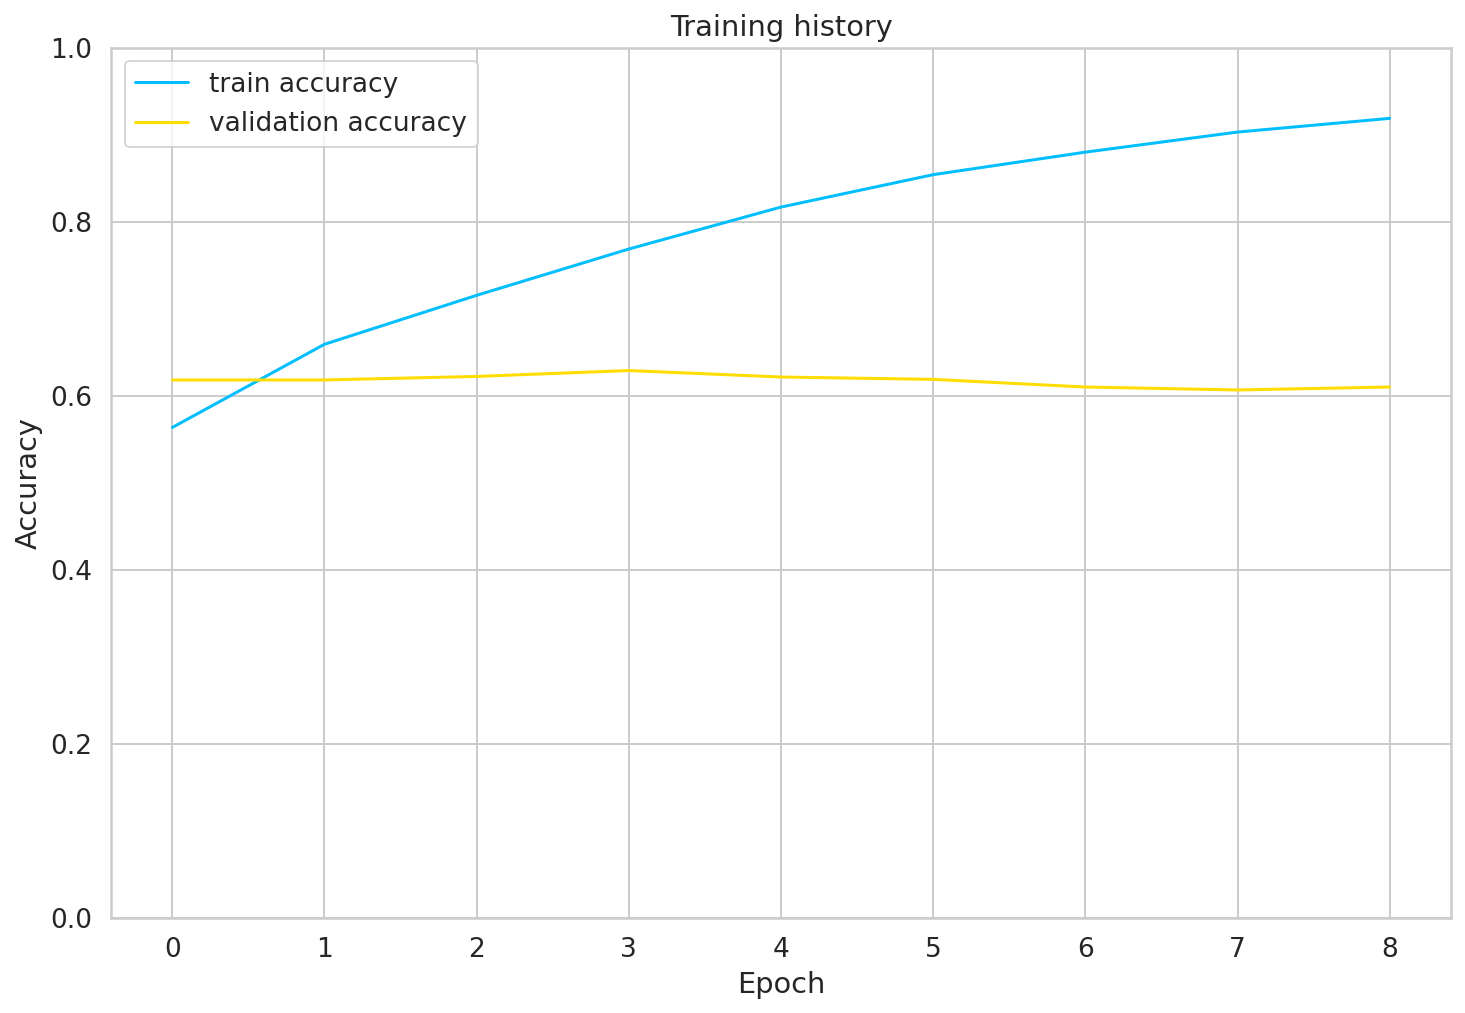

In [25]:
plt.plot([i.cpu() for i in history['train_acc']], label='train accuracy')
plt.plot([i.cpu() for i in history['val_acc']], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [26]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('Pretrained_RoBert_SRL(FC).bin'))
model = model.to(device)

Some weights of the model checkpoint at /home/bit/stock/model/pretrained-bert/ROBERT_4_model.bin were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /home/bit/stock/model/pretrained-bert/ROBERT_4_model.bin and are new

In [27]:
len(df_test)

1477

In [28]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.6161137440758293

In [29]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      verb = d["verb"].to(device)
      A0 = d["A0"].to(device)
      A1 = d["A1"].to(device)
      AV_num = d['AV_num'].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        verb = verb,
        A0 = A0,
        A1 = A1,
        AV_num = AV_num
      )
      if outputs.dim()==1:
        outputs = torch.unsqueeze(outputs,0)
      _, preds = torch.max(outputs, dim=1)
      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [30]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

              precision    recall  f1-score   support

    negative     0.6409    0.6343    0.6376       484
     neutral     0.5699    0.6139    0.5910       505
    positive     0.6454    0.6004    0.6221       488

    accuracy                         0.6161      1477
   macro avg     0.6187    0.6162    0.6169      1477
weighted avg     0.6181    0.6161    0.6165      1477



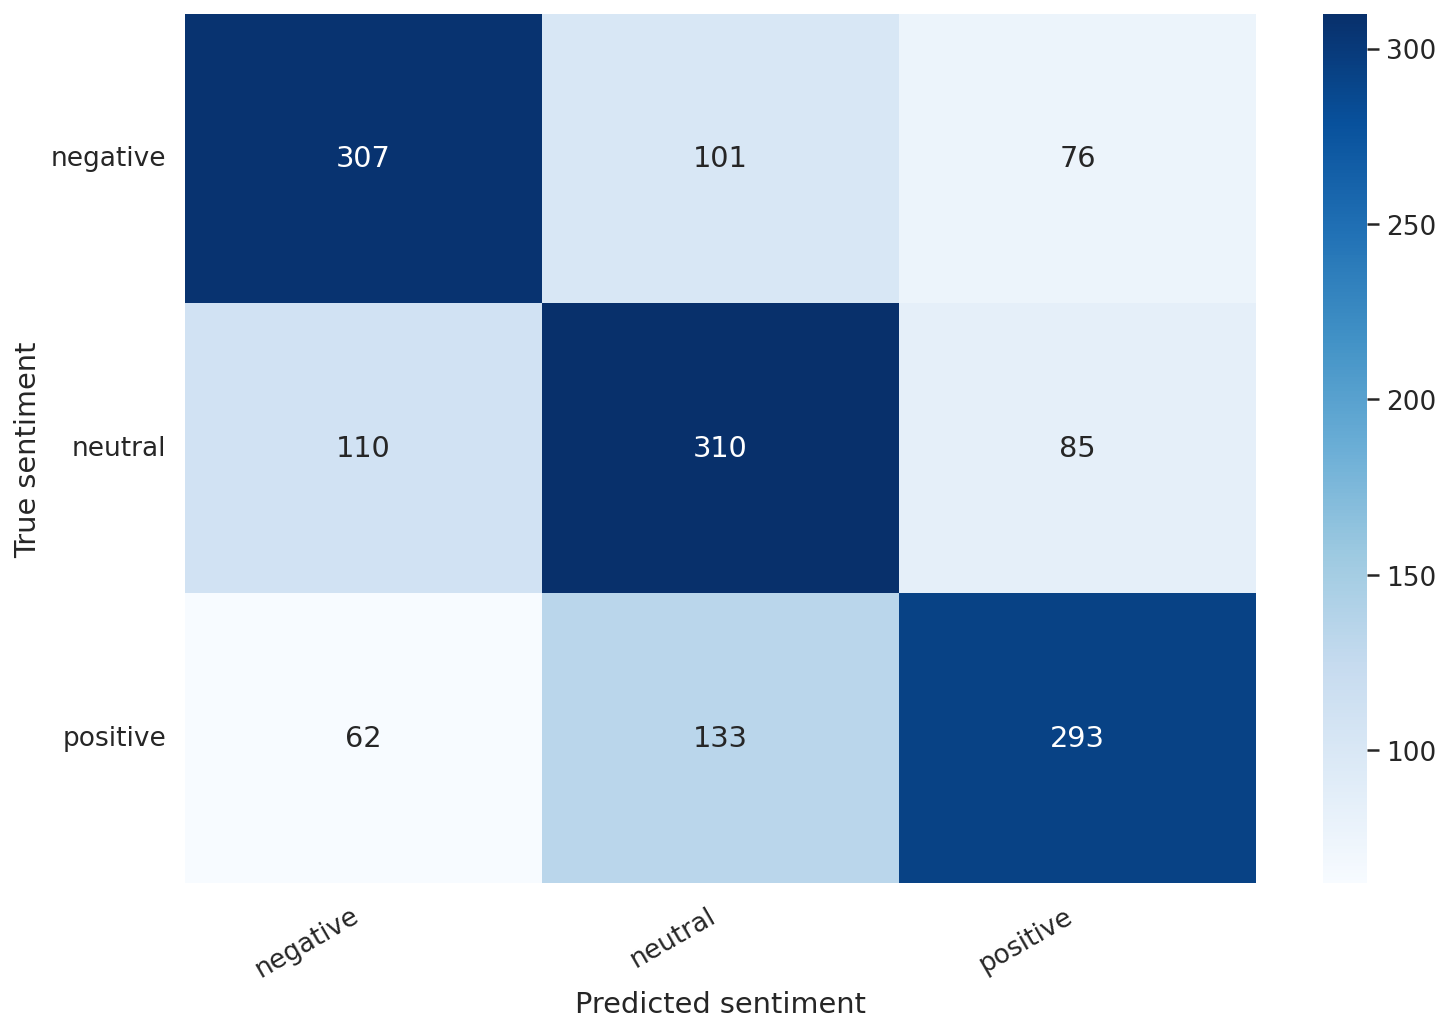

In [31]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred, target_names=class_names,digits=4))



cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [32]:
df = pd.DataFrame([y_review_texts, y_pred.numpy(), y_pred_probs.numpy(), y_test.numpy()]).T
df = df.rename(columns={0:'text',1:'prediction',2:'probability',3:'labels'})
df.to_csv('Pretrained_RoBert_SRL(FC)_test.csv',sep='\t')

              precision    recall  f1-score   support

    negative     0.6235    0.5713    0.5963      3133
     neutral     0.5423    0.5810    0.5610      3406
    positive     0.6096    0.6128    0.6112      3618

    accuracy                         0.5893     10157
   macro avg     0.5918    0.5884    0.5895     10157
weighted avg     0.5913    0.5893    0.5898     10157



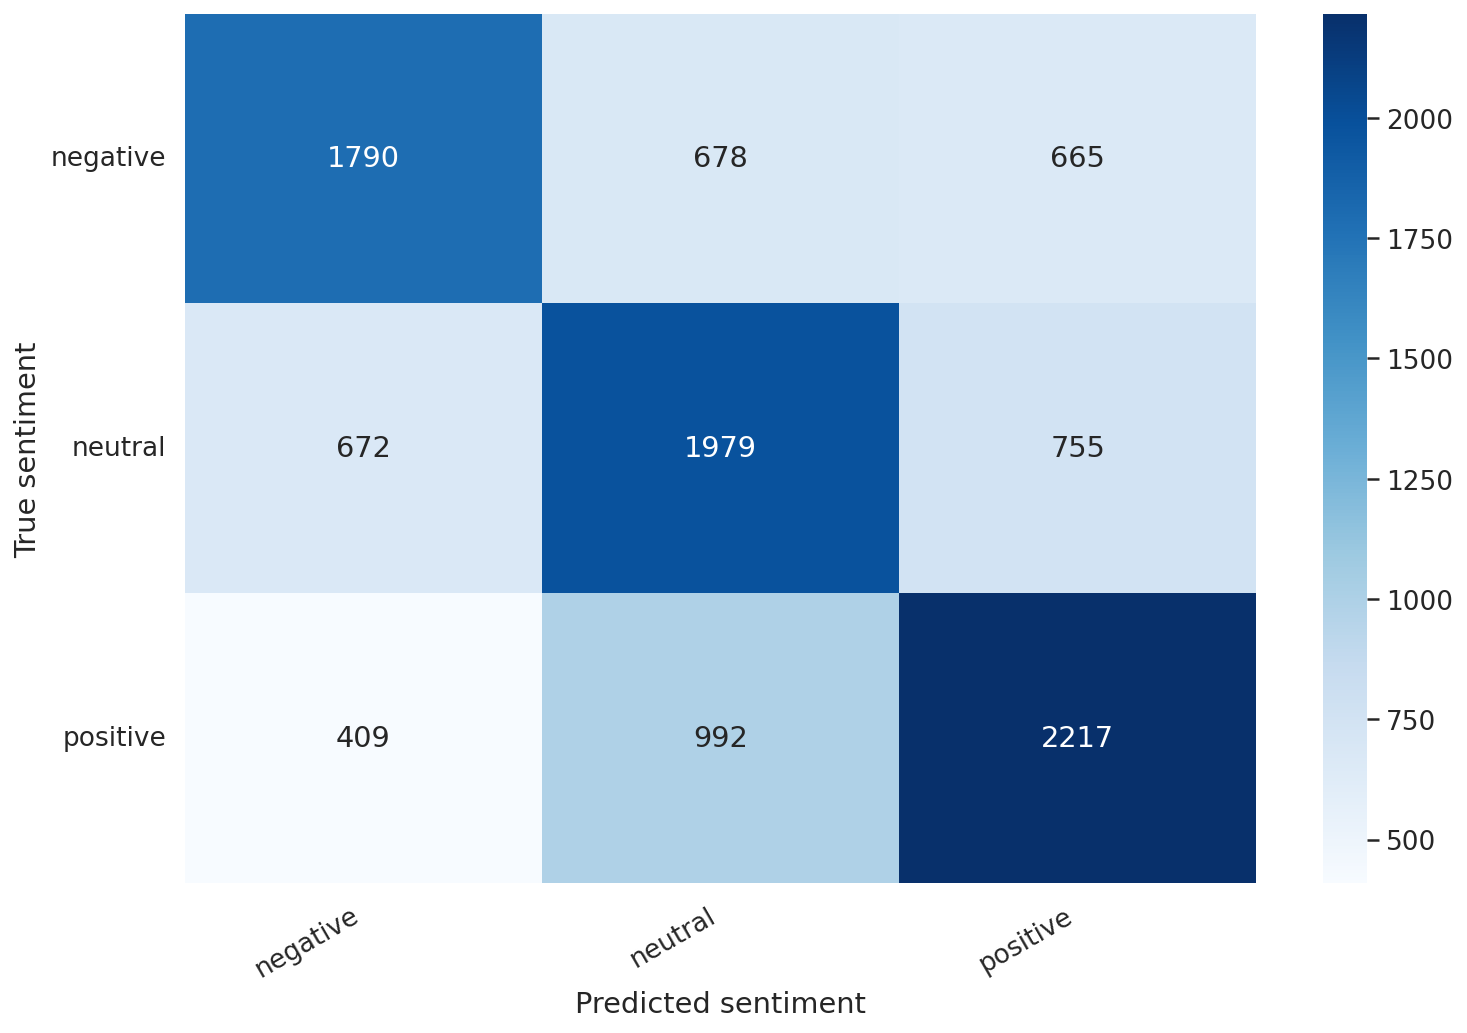

In [33]:
y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)

              precision    recall  f1-score   support

    negative     0.6105    0.5684    0.5887       943
     neutral     0.5199    0.5750    0.5461       953
    positive     0.6607    0.6429    0.6517      1330

    accuracy                         0.6011      3226
   macro avg     0.5970    0.5954    0.5955      3226
weighted avg     0.6044    0.6011    0.6021      3226



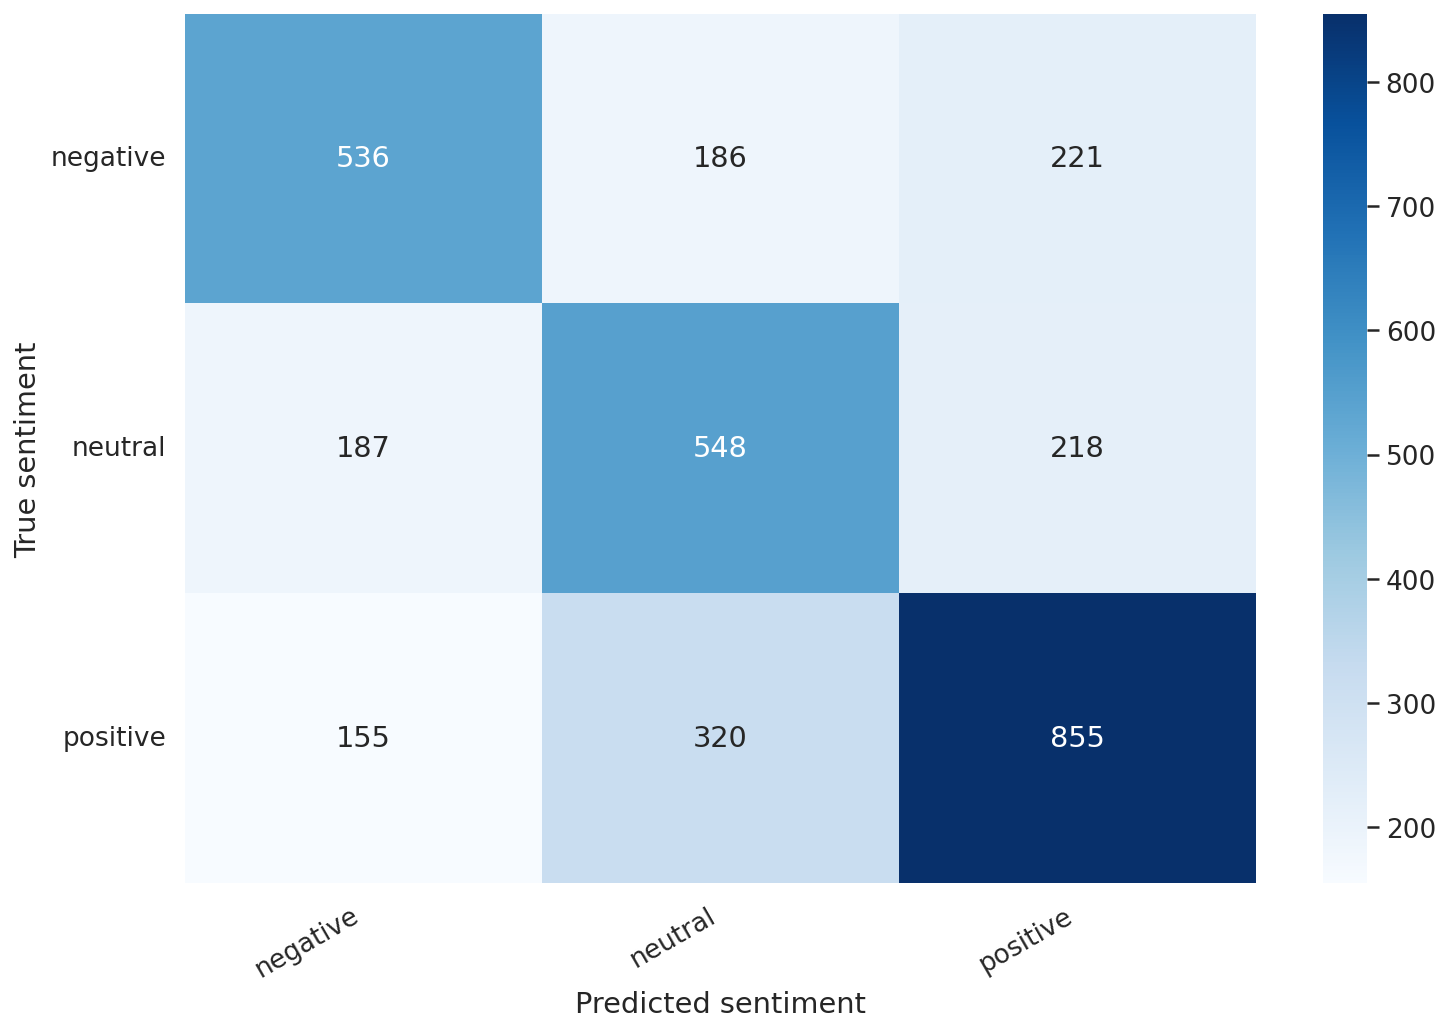

              precision    recall  f1-score   support

    negative     0.6371    0.6116    0.6241       623
     neutral     0.6317    0.6133    0.6224       825
    positive     0.6147    0.6528    0.6332       792

    accuracy                         0.6268      2240
   macro avg     0.6279    0.6259    0.6266      2240
weighted avg     0.6272    0.6268    0.6267      2240



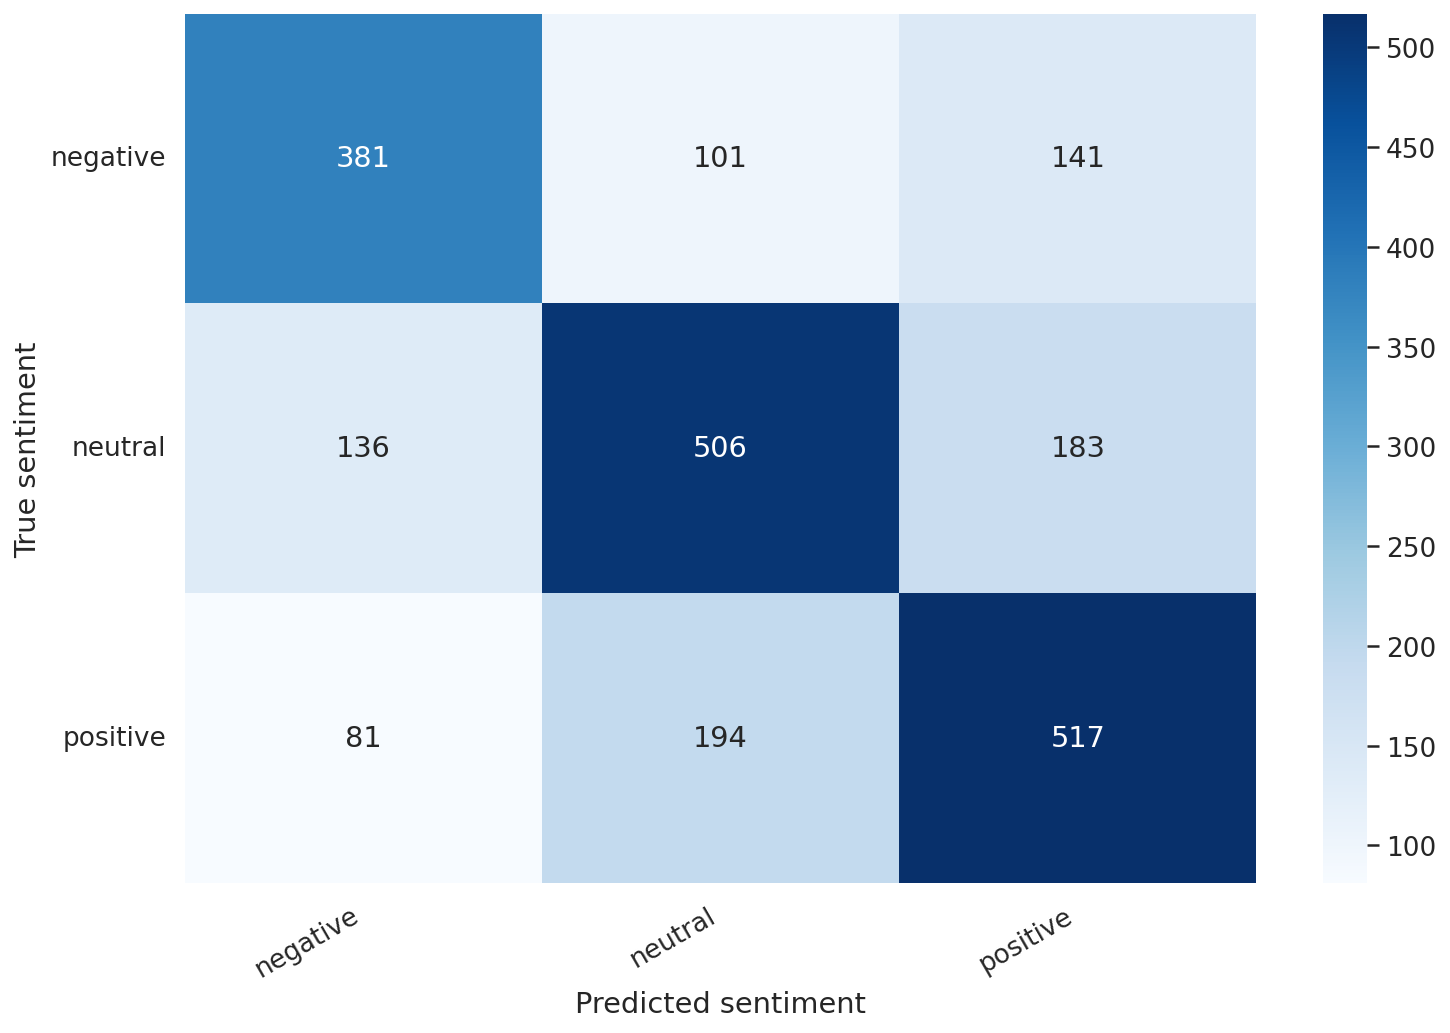

              precision    recall  f1-score   support

    negative     0.6404    0.5557    0.5951      1157
     neutral     0.5133    0.5629    0.5369      1169
    positive     0.5548    0.5751    0.5647      1092

    accuracy                         0.5644      3418
   macro avg     0.5695    0.5646    0.5656      3418
weighted avg     0.5696    0.5644    0.5655      3418



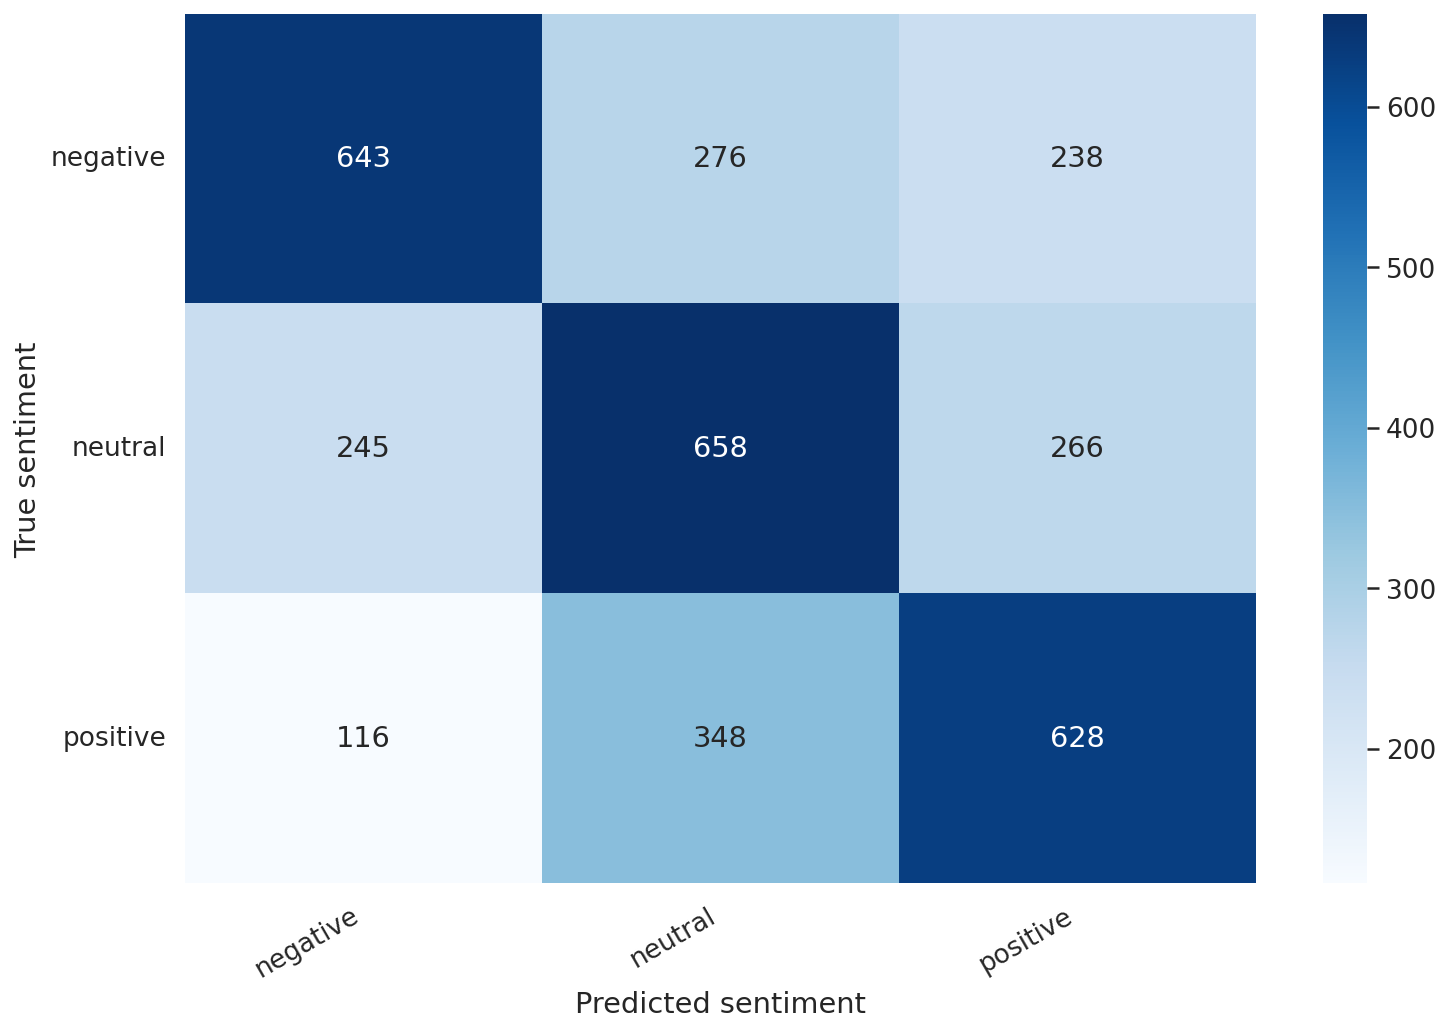

              precision    recall  f1-score   support

    negative     0.5896    0.5619    0.5754       404
     neutral     0.5161    0.5749    0.5439       447
    positive     0.5702    0.5223    0.5452       381

    accuracy                         0.5544      1232
   macro avg     0.5586    0.5530    0.5548      1232
weighted avg     0.5569    0.5544    0.5546      1232



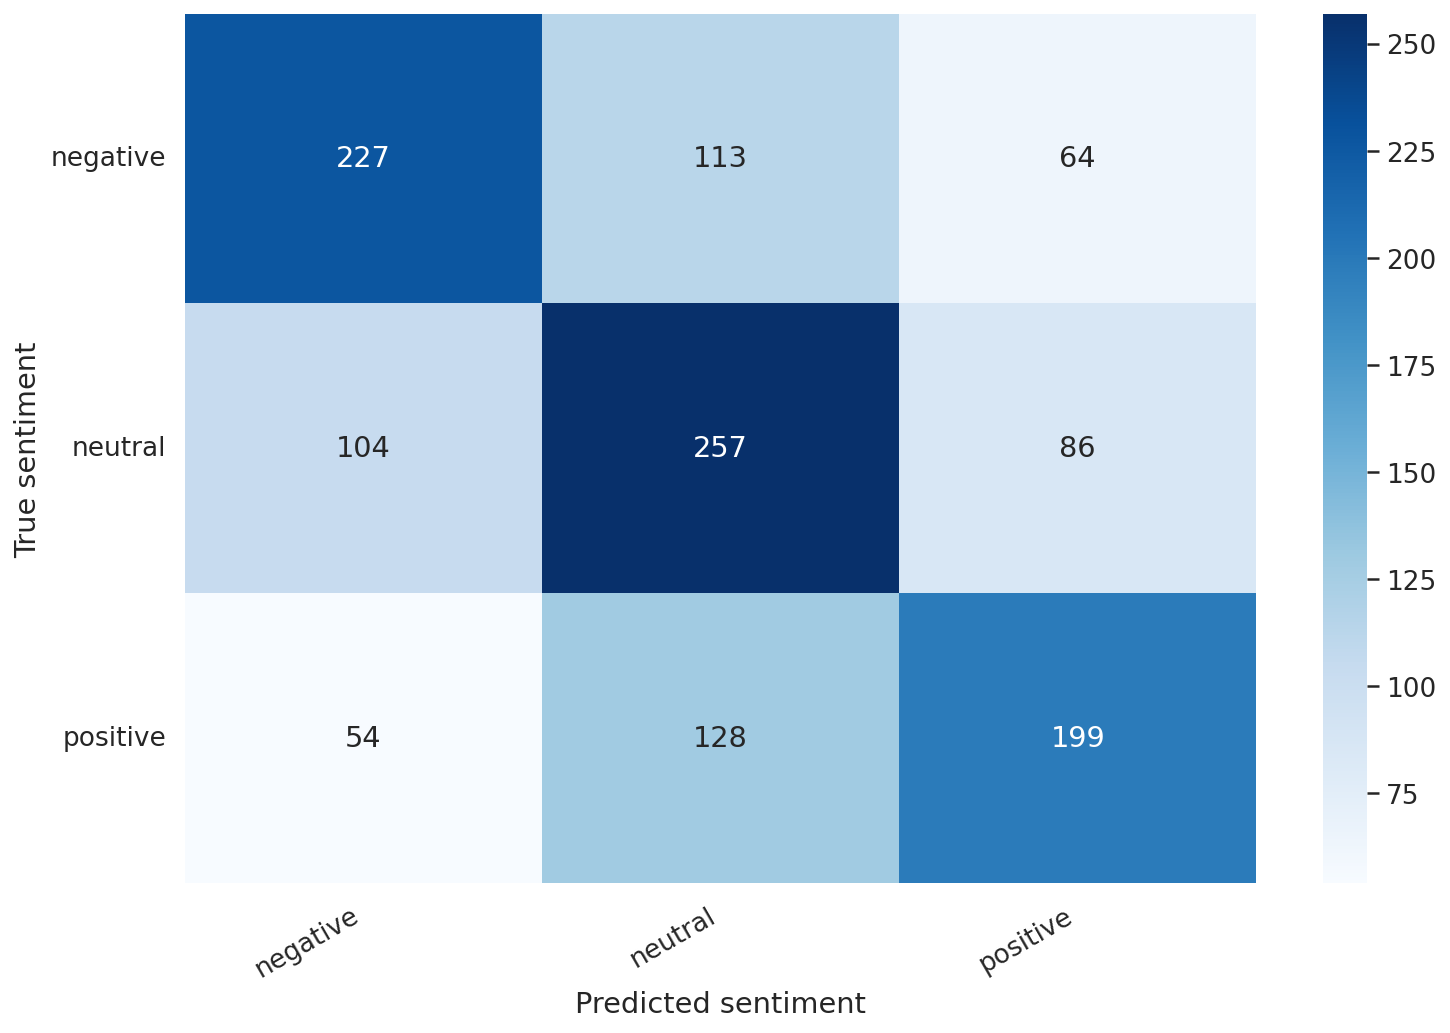

In [34]:
df_ood = pd.read_csv('../data/pre/ood.csv',sep='\t')
df_ood = df_ood.loc[(df_ood.DATE>='2021-01-01')&(df_ood.DATE<='2021-03-31')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)
plt.show()

df_ood = pd.read_csv('../data/pre/ood.csv',sep='\t')
df_ood = df_ood.loc[(df_ood.DATE>='2021-04-01')&(df_ood.DATE<='2021-06-31')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)
plt.show()

df_ood = pd.read_csv('../data/pre/ood.csv',sep='\t')
df_ood = df_ood.loc[(df_ood.DATE>='2021-07-01')&(df_ood.DATE<='2021-09-31')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)
plt.show()

df_ood = pd.read_csv('../data/pre/ood.csv',sep='\t')
df_ood = df_ood.loc[df_ood.DATE>='2021-10-01']
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)
plt.show()

              precision    recall  f1-score   support

    negative     0.0000    0.0000    0.0000         0
     neutral     1.0000    0.4080    0.5795     16798
    positive     0.0000    0.0000    0.0000         0

    accuracy                         0.4080     16798
   macro avg     0.3333    0.1360    0.1932     16798
weighted avg     1.0000    0.4080    0.5795     16798



/home/bit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


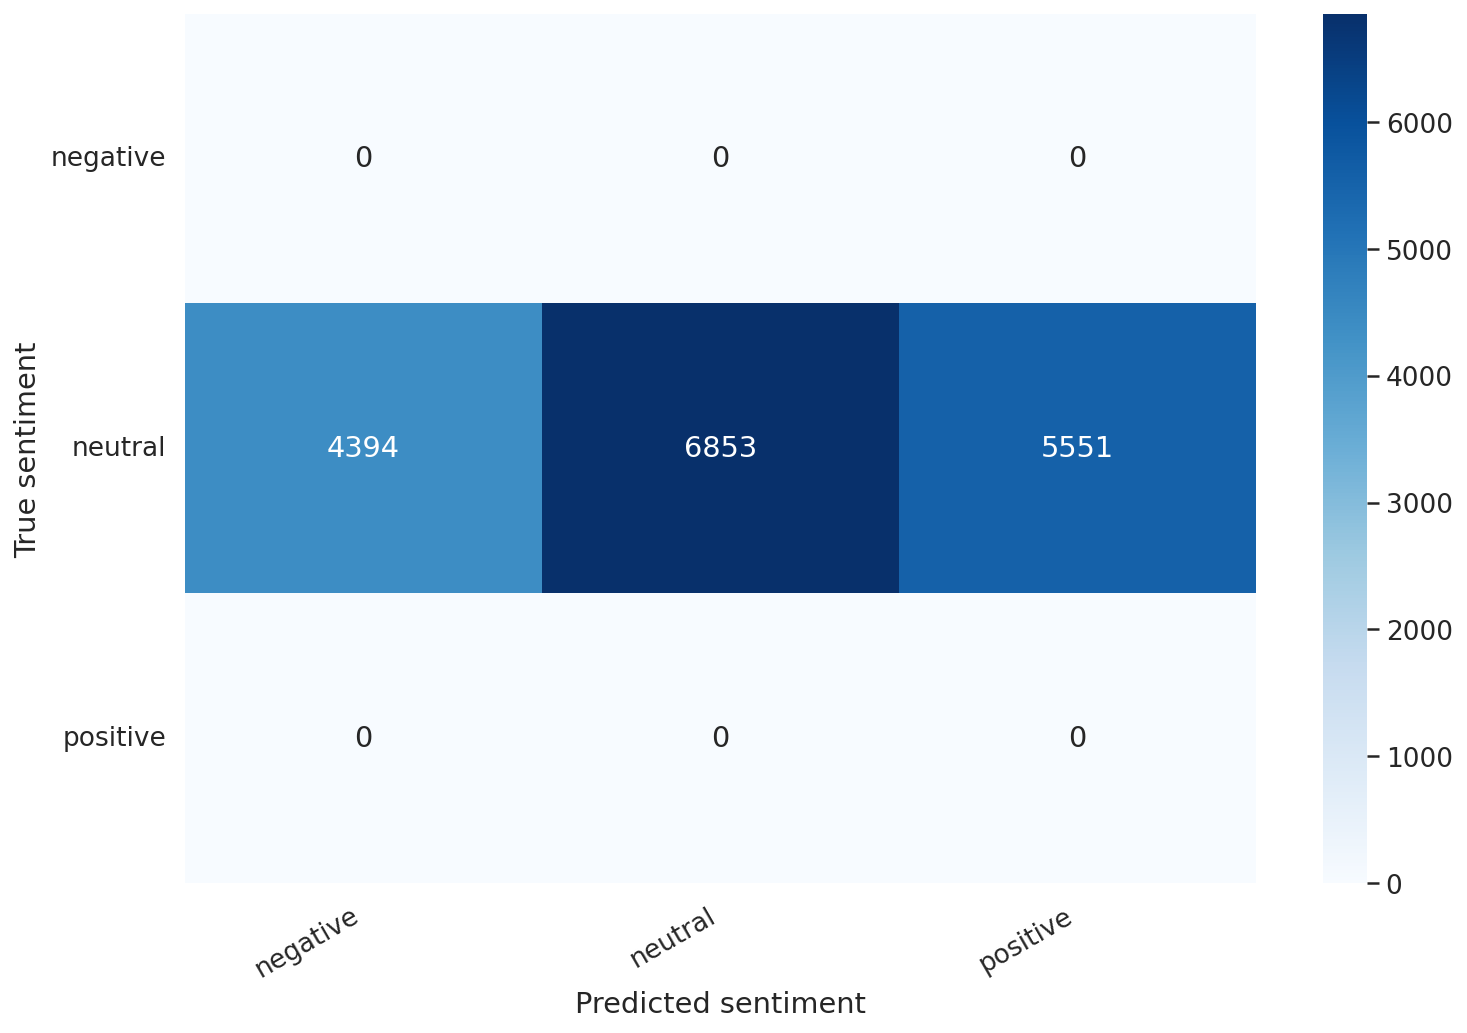

In [35]:
df_ood = pd.read_csv('../data/df_all_year_srl.csv',sep='\t')
# df_ood = df_ood.loc[(df_ood.DATE>='2021-05-05')&(df_ood.DATE<='2021-09-01')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:2000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)

In [36]:
df = pd.DataFrame([y_ood_review_texts, y_ood_pred.numpy(), y_ood_pred_probs.numpy(), y_ood.numpy()]).T
df = df.rename(columns={0:'text',1:'prediction',2:'probability',3:'labels'})
df.to_csv('Pretrained_RoBert_SRL(FC)_ood.csv',sep='\t')

In [37]:
# !pip install lit-nlp

In [38]:
# from lit_nlp.api.dataset import Dataset
# class MultiNLIData(Dataset):
#   """Loader for MultiNLI development set."""
#   def __init__(self, df):
#     # Read the eval set from a .tsv file as distributed with the GLUE benchmark.
#     # df = pandas.read_csv(path, sep='\t')
#     # Store as a list of dicts, conforming to self.spec()
#     self.LABELS = [0,1]
#     self._examples = [{
#       'sentence': row['DESCRIPTION_EN'],
#       # 'hypothesis': row['sentence2'],
#       'label': row['LABEL']
#       # 'genre': row['genre'],
#     } for _, row in df.iterrows()]
#   def spec(self):
#     return {
#       'sentence': lit_types.TextSegment(),
#       # 'hypothesis': lit_types.TextSegment(),
#       'label': lit_types.CategoryLabel(vocab=self.LABELS),
#       # We can include additional fields, which don't have to be used by the model.
#       # 'genre': lit_types.Label(),
#     }

In [39]:
# from absl import app
# from absl import flags
# from absl import logging

# from lit_nlp import dev_server
# from lit_nlp import server_flags
# from lit_nlp.api import model as lit_model
# from lit_nlp.api import types as lit_types
# # Use the regular GLUE data loaders, because these are very simple already.
# from lit_nlp.examples.datasets import glue
# from lit_nlp.lib import utils

# import torch
# import transformers

# # NOTE: additional flags defined in server_flags.py

# FLAGS = flags.FLAGS

# flags.DEFINE_string(
#     "model_path",
#     "https://storage.googleapis.com/what-if-tool-resources/lit-models/sst2_tiny.tar.gz",
#     "Path to trained model, in standard transformers format, e.g. as "
#     "saved by model.save_pretrained() and tokenizer.save_pretrained()")


# def _from_pretrained(cls, *args, **kw):
#   """Load a transformers model in PyTorch, with fallback to TF2/Keras weights."""
#   try:
#     return cls.from_pretrained(*args, **kw)
#   except OSError as e:
#     logging.warning("Caught OSError loading model: %s", e)
#     logging.warning(
#         "Re-trying to convert from TensorFlow checkpoint (from_tf=True)")
#     return cls.from_pretrained(*args, from_tf=True, **kw)


# class SimpleSentimentModel(lit_model.Model):
#   """Simple sentiment analysis model."""

#   LABELS = [0,1]  # negative, positive

#   def __init__(self, model_name_or_path):
#     self.tokenizer = transformers.AutoTokenizer.from_pretrained(
#         model_name_or_path)
#     model_config = transformers.AutoConfig.from_pretrained(
#         model_name_or_path,
#         num_labels=2,
#         output_hidden_states=True,
#         output_attentions=True,
#     )
#     # This is a just a regular PyTorch model.
#     self.model = _from_pretrained(
#         transformers.AutoModelForSequenceClassification,
#         model_name_or_path,
#         config=model_config)
#     self.model.eval()

#   ##
#   # LIT API implementation
#   def max_minibatch_size(self):
#     # This tells lit_model.Model.predict() how to batch inputs to
#     # predict_minibatch().
#     # Alternately, you can just override predict() and handle batching yourself.
#     return 16

#   def predict_minibatch(self, inputs):
#     # Preprocess to ids and masks, and make the input batch.
#     encoded_input = self.tokenizer.batch_encode_plus(
#         [ex["sentence"] for ex in inputs],
#         return_tensors="pt",
#         add_special_tokens=True,
#         max_length=200,
#         padding="longest",
#         truncation="longest_first")

#     # Check and send to cuda (GPU) if available
#     if torch.cuda.is_available():
#       self.model.cuda()
#       for tensor in encoded_input:
#         encoded_input[tensor] = encoded_input[tensor].cuda()
#     # Run a forward pass.
#     with torch.no_grad():  # remove this if you need gradients.
#       out: transformers.modeling_outputs.SequenceClassifierOutput = \
#           self.model(**encoded_input)

#     # Post-process outputs.
#     batched_outputs = {
#         "probas": torch.nn.functional.softmax(out.logits, dim=-1),
#         "input_ids": encoded_input["input_ids"],
#         "ntok": torch.sum(encoded_input["attention_mask"], dim=1),
#         "cls_emb": out.hidden_states[-1][:, 0],  # last layer, first token
#     }
#     # Return as NumPy for further processing.
#     detached_outputs = {k: v.cpu().numpy() for k, v in batched_outputs.items()}
#     # Unbatch outputs so we get one record per input example.
#     for output in utils.unbatch_preds(detached_outputs):
#       ntok = output.pop("ntok")
#       output["tokens"] = self.tokenizer.convert_ids_to_tokens(
#           output.pop("input_ids")[1:ntok - 1])
#       yield output

#   def input_spec(self) -> lit_types.Spec:
#     return {
#         "sentence": lit_types.TextSegment(),
#         "label": lit_types.CategoryLabel(vocab=self.LABELS, required=False)
#     }

#   def output_spec(self) -> lit_types.Spec:
#     return {
#         "tokens": lit_types.Tokens(),
#         "probas": lit_types.MulticlassPreds(parent="label", vocab=self.LABELS),
#         "cls_emb": lit_types.Embeddings()
#     }


In [40]:
# dataset = MultiNLIData(df_train.sample(1800))

In [41]:
# datasets = {"sst_dev": dataset}
# models = {"sst": SimpleSentimentModel("/content/drive/MyDrive/model/best_model/")}
# # models = {"sst": SimpleSentimentModel("bert-base-uncased")}

In [42]:
# from lit_nlp import notebook
# widget = notebook.LitWidget(models, datasets, height=800)

In [43]:
# mm = models["sst"]

In [44]:
# mm.model.config

In [45]:
# widget.render()

In [46]:
# dataset.LABELS
